# 1. Setup

In [1]:
import pandas as pd
import utils 
from utils import *
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.pipeline import Pipeline
import gensim
from gensim.models import KeyedVectors

# 2. Data loading

First, we will load the pre-processed datasets.

In [2]:
# Load the data
data_train = load_preprocessed_data()

In [3]:
# Calculate the number of positive and negative tweets
num_positive = len(data_train[data_train["label"] == 1])
num_negative = len(data_train[data_train["label"] == -1])
total_tweets = data_train.shape[0]

# Calculate the percentages
perc_positive = num_positive / total_tweets * 100
perc_negative = num_negative / total_tweets * 100

# Print the information
print("Number of total tweets:", total_tweets)
print("Percentage of positive tweets: {:.2f}%".format(perc_positive))
print("Percentage of negative tweets: {:.2f}%".format(perc_negative))

Number of total tweets: 181290
Percentage of positive tweets: 49.77%
Percentage of negative tweets: 50.23%


In [4]:
# Split the data into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(data_train["text"], data_train['label'], test_size=0.2, random_state=42)

# 3. Text Vectorizer

Now, we will conduct a grid search to identify the optimal text vectorizer from the followings :

- `Count Vectorizer`
- `TF-IDF Vectorizer`
- `Word2Vec`

This will include determining their best hyperparameters.

Note : Testing grid search on the full dataset, which comprises 2.5 million entries, is highly time-consuming. This is because the duration required for a grid search scales exponentially with the number of values that are being tested. Consequently, to manage this challenge effectively, we conducted the grid search on a smaller sample of the dataset, containing 200,000 entries. This approach ensures efficiency in processing time while retaining the integrity and representativeness of the data, thereby not resulting in significant information loss.

#### Count Vectorizer

The Count Vectorizer is a text analysis method that converts a collection of text documents into a matrix of token counts. This technique involves counting the number of times each word appears in a document, resulting in a sparse matrix where rows correspond to documents and columns correspond to tokens (usually words) in the entire dataset. It's a simple yet effective way to represent text data for machine learning algorithms.

In [5]:
# Define pipeline for Count Vectorizer
pipeline_count = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier())
])

# Parameter grid for Count Vectorizer pipeline
parameter_grid_count = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

# Grid search for Count Vectorizer pipeline
grid_search_count = GridSearchCV(pipeline_count, parameter_grid_count, cv=5)

# Fit the grid search to the data
grid_search_count.fit(X_train, y_train)

# After fitting, we can access the best parameters, best score, etc.
print("Count Vectorizer - Best parameters:", grid_search_count.best_params_)
print("Count Vectorizer - Best score:", grid_search_count.best_score_)

Count Vectorizer - Best parameters: {'vect__ngram_range': (1, 3)}
Count Vectorizer - Best score: 0.8135859756439612


#### TF-IDF Vectorizer

The TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency) is a more advanced technique compared to the Count Vectorizer. It reflects how important a word is to a document in a collection or corpus. The TF-IDF value increases proportionally with the number of times a word appears in the document but is offset by the frequency of the word in the corpus, which helps control for the fact that some words are generally more common than others. This method is particularly useful for feature extraction in text analysis, enabling better handling of common words and highlighting the unique aspects of each document.

In [6]:
# Define pipeline for TF-IDF
pipeline_tfidf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier())
])

# Parameter grid for TF-IDF pipeline
parameter_grid_tfidf = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

# Grid search for TF-IDF pipeline
grid_search_tfidf = GridSearchCV(pipeline_tfidf, parameter_grid_tfidf, cv=5)

# Fit the grid search to the data
grid_search_tfidf.fit(X_train, y_train)

# After fitting, you can access the best parameters, best score, etc.
print("TF-IDF - Best parameters:", grid_search_tfidf.best_params_)
print("TF-IDF - Best score:", grid_search_tfidf.best_score_)

TF-IDF - Best parameters: {'vect__ngram_range': (1, 1)}
TF-IDF - Best score: 0.7833305793955809


#### Word2Vec

Word2Vec is a popular method developed by Google. It uses either a Continuous Bag of Words (CBOW) or Skip-Gram model to transform words into dense vectors in a high-dimensional space. The key concept behind Word2Vec is that words with similar meanings tend to appear in similar contexts, so the algorithm captures semantic relationships between words based on their co-occurrence in text corpora.

We used Google's pre-trained Word2Vec model, which has been trained on a large Google News dataset and contains word vectors for 3 million words and phrases. The pre-trained model can be downloaded here : https://www.kaggle.com/datasets/adarshsng/googlenewsvectors/

In [7]:
# Load Google's pre-trained Word2Vec model.
model_path = 'GoogleNews-vectors-negative300.bin'
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)  

In [8]:
# Create an instance of the WordEmbeddingVectorizer with our Word2Vec model
word_vectorizer = WordEmbeddingVectorizer(word_vectors)

# Create a pipeline
pipeline = Pipeline([
    ('word2vec', word_vectorizer),
    ('classifier', SGDClassifier())
])

# Train the model
pipeline.fit(X_train, y_train)

# Calculate and print the accuracy
accuracy = pipeline.score(X_validation, y_validation)
print("Accuracy:", accuracy)

Accuracy: 0.6271167742291356


# 4. Optimization of the SGD model

We notice that the vectorizer that yields the best accuracy is `CountVectorizer` with the parameters `ngram_range=(1, 3)`. Now let's use it to find the best SGD hyperparameters with a grid search.

### Definition of the model

First, let's vectorize the data with the best vectorizer

In [9]:
# CountVectorizer
best_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_vectorized = best_vectorizer.fit_transform(X_train)
X_validation_vectorized = best_vectorizer.transform(X_validation)

Now let's train the SGD model with the vectorized data

In [10]:
# Instanciate an SGD classifier
clf = SGDClassifier()
start_time = time.time()
clf.fit(X_train_vectorized, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

# Get decision scores instead of binary predictions
y_train_scores = clf.decision_function(X_train_vectorized)
y_validation_scores = clf.decision_function(X_validation_vectorized)
print(f"Training time: {elapsed_time:.2f} sec")

Training time: 2.01 sec


### The decision boundary threshold

Now let's find the best decision boundary threshold for the positive and negative labels

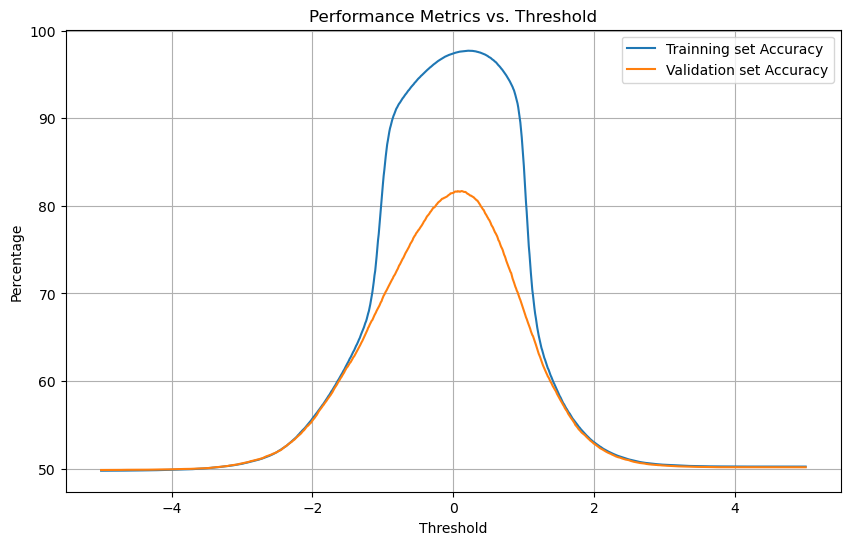

In [12]:
# Define the thresholds to test
thresholds = np.arange(-5, 5.01, 0.01)

# Initialize empty lists to store accuracy and F1 scores
train_accuracies = []
validation_accuracies = []

# Loop through each threshold
for threshold in thresholds:
    y_train_pred = np.where(y_train_scores >= threshold, 1, -1)
    y_validation_pred = np.where(y_validation_scores >= threshold, 1, -1)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    validation_accuracy = accuracy_score(y_validation, y_validation_pred)

    train_accuracies.append(train_accuracy * 100)
    validation_accuracies.append(validation_accuracy * 100)
    
# Create a line plot for training set
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies, label='Trainning set Accuracy')

# Create a line plot for validation set
plt.plot(thresholds, validation_accuracies, label='Validation set Accuracy')

plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Find the index of the max validation accuracy
max_accuracy_index = np.argmax(validation_accuracies)

# Get the corresponding threshold
optimal_threshold = thresholds[max_accuracy_index]

print(f"The threshold for maximum validation accuracy {validation_accuracies[max_accuracy_index]:.2f}% is: {optimal_threshold:.2f}")

The threshold for maximum validation accuracy 81.68% is: 0.12


Let's recall that the decision function returns an unbounded confidence score rather than a probability. Since the best threshold that we found is 0.06 (	$\approx$ 0.0), this is statistically coherent with the fact that the training data are balanced 50.2% negative and 49.8% positive. Therefore, we can keep the regular decision boundary of the SGD model which is 0.

### Grid search for optimal regularization

Now, let's implement some regularization methods to check if our model is overfitting the data. We will again conduct a grid search, focusing on the following parameters :

- `loss function`
- `penalty`
- `alpha`

In [14]:
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1'],
    'alpha': [0.001, 0.01, 0.1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log_loss', 'modified_huber'],
                         'penalty': ['l2', 'l1']},
             scoring='accuracy')

In [15]:
# Get the best parameters
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_parameters)
print(f"Best accuracy: {best_score*100:.2f}%")

# Predictions with the best model
y_pred = grid_search.predict(X_validation_vectorized)

Best parameters: {'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l2'}
Best accuracy: 81.04%


We observe that the best regularization results in a lower accuracy. From this, we can conclude that our model is not overfitting the data.

# 5. Testing and Submission using the Full Dataset

Now, let's proceed to test our optimal vectorizer and model on the full dataset (2.5M entries), and then make a submission on AIcrowd.

First, we load the full training dataset and the test data.

In [16]:
# Load the full data
full_data_train = load_preprocessed_full_data()
full_data_test = load_preprocessed_test_data()

In [17]:
# Prepare the data feature and target
X_train_full = full_data_train["text"]
y_train_full = full_data_train["label"]
X_test = full_data_test["text"]

Then we setup the optimal vectorizer with the optimal model.

In [18]:
# Use the optimal vectorizer: CountVectorizer with ngram_range=(1, 3)
full_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_full_vectorized = full_vectorizer.fit_transform(X_train_full)
X_test_vectorized = full_vectorizer.transform(X_test)

In [19]:
# Use the SGD model without any regularization
clf_submission = SGDClassifier()
clf.fit(X_train_full_vectorized, y_train_full)

SGDClassifier()

Finally, we can make the prediciton and make a submission.

In [20]:
# Make the prediction
y_test_pred = clf.predict(X_test_vectorized)

In [21]:
# Export the prediction
export_submission(y_test_pred)

This submission to AIcrowd achieved the following accuracy scores:
    
- First Score = 0.836
- Second Score = 0.841

This appears quite promising. Let's now experiment with a different model: **Logistic Regression**.